# MNIST Digit Recognization with Neural Networks

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization, Convolution2D, Dense, Dropout, Flatten, Lambda, MaxPooling2D
from keras.models import  Sequential
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

## Load training dataset and get basic information

In [66]:
train = pd.read_csv('train.csv')

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [68]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
train['label'].unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

In [70]:
for i in range(10):
    print('Number of training examples with label ',i,':',np.sum(train['label']==i))

Number of training examples with label  0 : 4132
Number of training examples with label  1 : 4684
Number of training examples with label  2 : 4177
Number of training examples with label  3 : 4351
Number of training examples with label  4 : 4072
Number of training examples with label  5 : 3795
Number of training examples with label  6 : 4137
Number of training examples with label  7 : 4401
Number of training examples with label  8 : 4063
Number of training examples with label  9 : 4188


In [71]:
X_train = train.iloc[:,1:].values.astype('float32')
y_train = train.iloc[:,0].values.astype('int32')
img_dim = int(np.sqrt(len(X_train[0])))
X_train = X_train.reshape(X_train.shape[0],img_dim,img_dim)

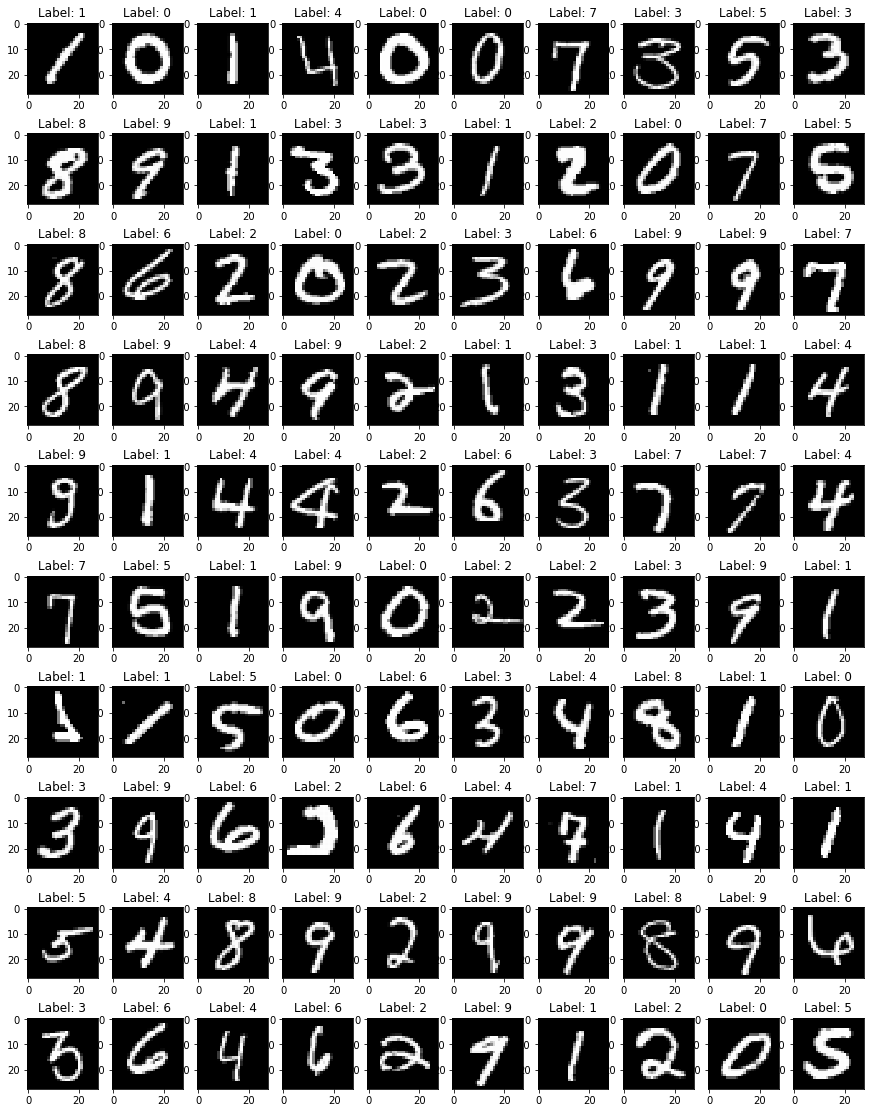

In [72]:
nrow = 10
ncol = 10
fig, axes = plt.subplots(nrow,ncol,figsize=(1.5*ncol,2*nrow))
for i in range(nrow*ncol):
    ax = axes[i//ncol,i%ncol]
    ax.imshow(X_train[i],cmap=plt.get_cmap('gray'))
    ax.set_title('Label: '+str(y_train[i]))

## Pre-process Data
In this case, we simply need to standardize the features and encode the labels.

In [73]:
# Compute mean and standard deviation, and save these for later
train_mean = X_train.mean()
train_std = X_train.std()

In [74]:
X_train = (X_train-train_mean)/train_std

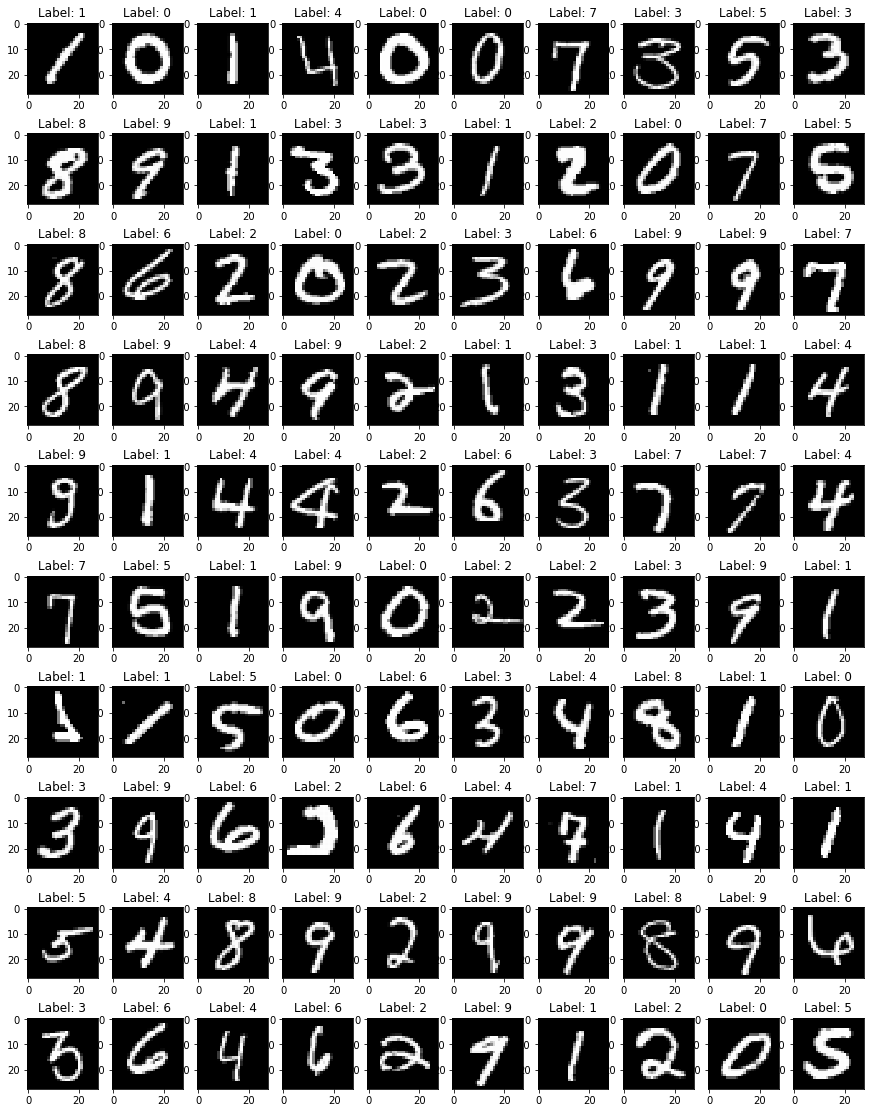

In [75]:
# Visualize sample digits now that they are normalized 
nrow = 10
ncol = 10
fig, axes = plt.subplots(nrow,ncol,figsize=(1.5*ncol,2*nrow))
for i in range(nrow*ncol):
    ax = axes[i//ncol,i%ncol]
    ax.imshow(X_train[i].reshape(img_dim,img_dim),cmap=plt.get_cmap('gray'))
    ax.set_title('Label: '+str(y_train[i]))

# t-SNE Visualization

In [12]:
# Flatten images into 1D
X_train = X_train.reshape(X_train.shape[0],img_dim*img_dim)

In [52]:
# Get subset to visualize (note: ordering is already randomized, so we can simply select a range)
X_viz = X_train[:10000]

In [53]:
X_embedded = TSNE(n_components=2).fit_transform(X_viz)

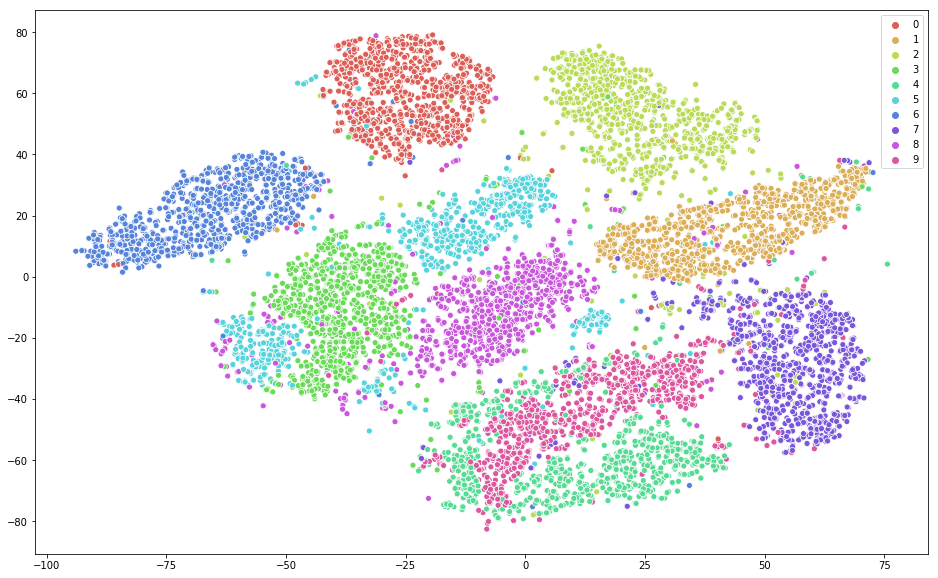

In [54]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_embedded[:,0], y=X_embedded[:,1],
    hue=y_train[:len(X_embedded)],
    palette=sns.color_palette("hls", 10),
    legend="full"
)

# PCA Approach
Now let's take the first 50 components of the full dataset to use for t-SNE on reduced dimension dataset. We will also visualize the 2D projection of the dataset from the first two components of PCA.

In [55]:
X_pca = PCA(n_components=50).fit_transform(X_train)

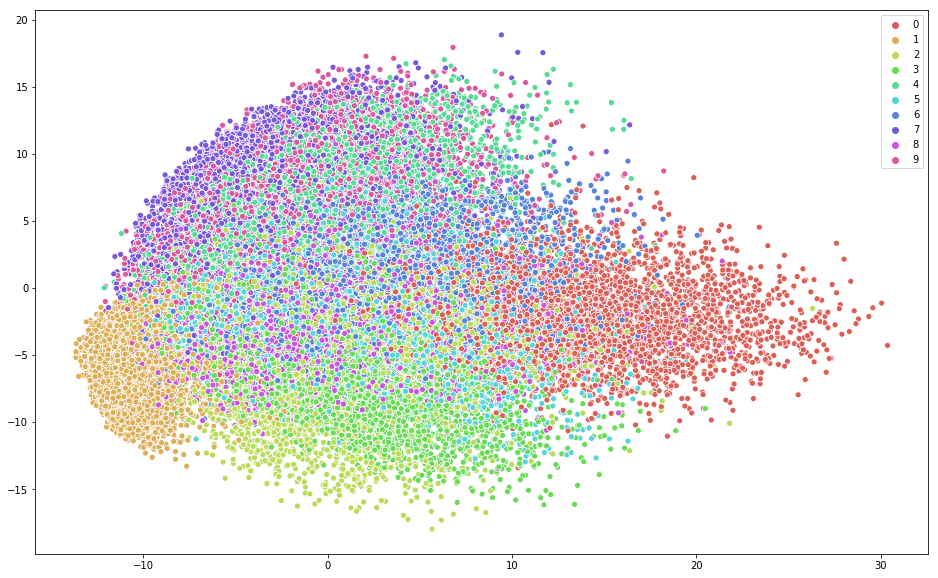

In [57]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y_train[:len(X_pca)],
    palette=sns.color_palette("hls", 10),
    legend="full"
)

# t-SNE visualization on reduced dataset after PCA dimension reduction

In [59]:
X_pca_red = X_pca[:10000]

In [60]:
X_pca_embedded = TSNE(n_components=2).fit_transform(X_pca_red)

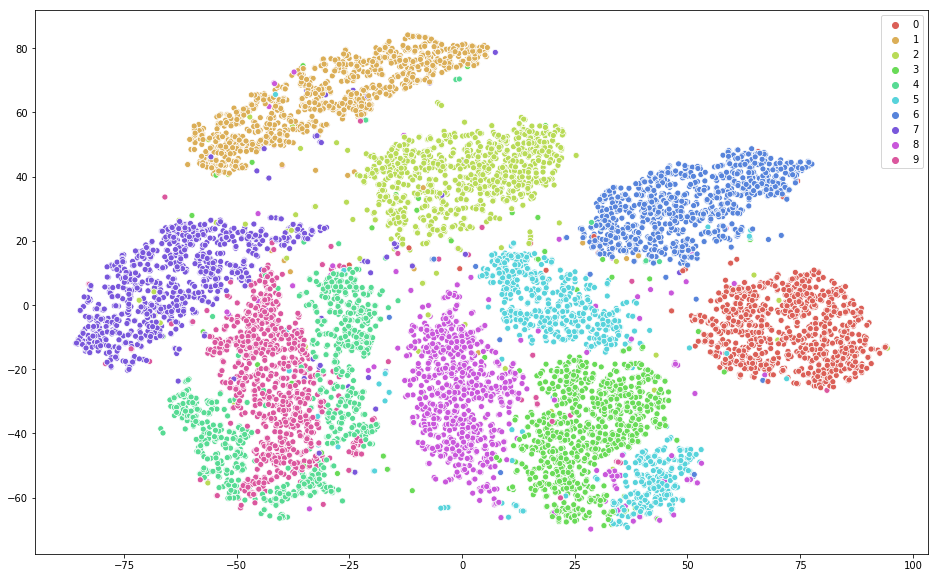

In [61]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=X_pca_embedded[:,0], y=X_pca_embedded[:,1],
    hue=y_train[:len(X_pca_embedded)],
    palette=sns.color_palette("hls", 10),
    legend="full"
)

## Convert labels to categorical and reshape images to original dims

In [76]:
y_train = to_categorical(y_train)
num_classes = y_train.shape[1]

In [63]:
X_train = X_train.reshape(X_train.shape[0],img_dim,img_dim)

## Linear Model

In [77]:
# Split into training and validation sets, saving original set as X and y
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)

In [78]:
d_in = X_train.shape[1]
d_out = num_classes

In [79]:
model = Sequential()
model.add(Flatten())
model.add(Dense(d_out, input_dim=d_in, activation='softmax'))
model.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('linear.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(X_train,y_train,epochs=20,verbose=2,callbacks=[es,mcp_save],validation_split=0.25)

Train on 28350 samples, validate on 9450 samples
Epoch 1/20
 - 2s - loss: 0.5103 - accuracy: 0.8484 - val_loss: 0.3706 - val_accuracy: 0.8935
Epoch 2/20
 - 3s - loss: 0.3438 - accuracy: 0.8993 - val_loss: 0.3319 - val_accuracy: 0.9065
Epoch 3/20
 - 2s - loss: 0.3168 - accuracy: 0.9076 - val_loss: 0.3204 - val_accuracy: 0.9108
Epoch 4/20
 - 2s - loss: 0.3019 - accuracy: 0.9130 - val_loss: 0.3098 - val_accuracy: 0.9115
Epoch 5/20
 - 2s - loss: 0.2923 - accuracy: 0.9158 - val_loss: 0.3035 - val_accuracy: 0.9145
Epoch 6/20
 - 2s - loss: 0.2854 - accuracy: 0.9176 - val_loss: 0.2994 - val_accuracy: 0.9169
Epoch 7/20
 - 2s - loss: 0.2790 - accuracy: 0.9201 - val_loss: 0.2977 - val_accuracy: 0.9162
Epoch 8/20
 - 2s - loss: 0.2749 - accuracy: 0.9216 - val_loss: 0.2938 - val_accuracy: 0.9186
Epoch 9/20
 - 2s - loss: 0.2703 - accuracy: 0.9235 - val_loss: 0.2954 - val_accuracy: 0.9182
Epoch 10/20
 - 2s - loss: 0.2668 - accuracy: 0.9240 - val_loss: 0.2927 - val_accuracy: 0.9179
Epoch 11/20
 - 2s - 

In [80]:
model.load_weights('linear.mdl_wts.hdf5')

In [81]:
train_loss, train_acc = model.evaluate(X_train,y_train)
print('Model Accuracy on Train Set: ',train_acc)

37800/37800 [==============================] - 1s 32us/step
Model Accuracy on Train Set:  0.9294973611831665


In [82]:
val_loss, val_acc = model.evaluate(X_val,y_val)
print('Model Accuracy on Validation Set: ',val_acc)

4200/4200 [==============================] - 0s 54us/step
Model Accuracy on Validation Set:  0.9178571701049805


# Fully Connected

In [83]:
model = Sequential()
model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dense(d_out, input_dim=d_in, activation='softmax'))
model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('FC.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(X_train,y_train,epochs=20,verbose=2,callbacks=[es,mcp_save],validation_split=0.25)

Train on 28350 samples, validate on 9450 samples
Epoch 1/20
 - 10s - loss: 0.2387 - accuracy: 0.9268 - val_loss: 0.1466 - val_accuracy: 0.9540
Epoch 2/20
 - 10s - loss: 0.1015 - accuracy: 0.9682 - val_loss: 0.1219 - val_accuracy: 0.9642
Epoch 3/20
 - 9s - loss: 0.0665 - accuracy: 0.9789 - val_loss: 0.1307 - val_accuracy: 0.9628
Epoch 4/20
 - 7s - loss: 0.0500 - accuracy: 0.9838 - val_loss: 0.1281 - val_accuracy: 0.9655
Epoch 5/20
 - 7s - loss: 0.0410 - accuracy: 0.9861 - val_loss: 0.1139 - val_accuracy: 0.9719
Epoch 6/20
 - 8s - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.1344 - val_accuracy: 0.9669
Epoch 7/20
 - 7s - loss: 0.0252 - accuracy: 0.9911 - val_loss: 0.1355 - val_accuracy: 0.9706
Epoch 8/20
 - 7s - loss: 0.0267 - accuracy: 0.9915 - val_loss: 0.1385 - val_accuracy: 0.9684
Epoch 9/20
 - 8s - loss: 0.0234 - accuracy: 0.9921 - val_loss: 0.1473 - val_accuracy: 0.9708
Epoch 10/20
 - 8s - loss: 0.0274 - accuracy: 0.9910 - val_loss: 0.1374 - val_accuracy: 0.9724
Epoch 11/20
 - 7s 

In [85]:
model.load_weights('FC.mdl_wts.hdf5')

In [86]:
train_loss, train_acc = model.evaluate(X_train,y_train)
print('Model Accuracy on Train Set: ',train_acc)

37800/37800 [==============================] - 4s 98us/step
Model Accuracy on Train Set:  0.9857671856880188


In [87]:
val_loss, val_acc = model.evaluate(X_val,y_val)
print('Model Accuracy on Validation Set: ',val_acc)

4200/4200 [==============================] - 0s 95us/step
Model Accuracy on Validation Set:  0.9695237874984741


# Fully Connected with Dropout

In [88]:
model = Sequential()
model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(d_out, input_dim=d_in, activation='softmax'))
model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('FCDO.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(X_train,y_train,epochs=50,verbose=2,callbacks=[es,mcp_save],validation_split=0.25)

Train on 28350 samples, validate on 9450 samples
Epoch 1/50
 - 11s - loss: 0.3426 - accuracy: 0.8935 - val_loss: 0.1699 - val_accuracy: 0.9520
Epoch 2/50
 - 11s - loss: 0.1856 - accuracy: 0.9430 - val_loss: 0.1271 - val_accuracy: 0.9628
Epoch 3/50
 - 10s - loss: 0.1513 - accuracy: 0.9538 - val_loss: 0.1187 - val_accuracy: 0.9666
Epoch 4/50
 - 11s - loss: 0.1397 - accuracy: 0.9564 - val_loss: 0.1172 - val_accuracy: 0.9687
Epoch 5/50
 - 13s - loss: 0.1276 - accuracy: 0.9611 - val_loss: 0.1084 - val_accuracy: 0.9708
Epoch 6/50
 - 8s - loss: 0.1156 - accuracy: 0.9636 - val_loss: 0.1168 - val_accuracy: 0.9675
Epoch 7/50
 - 8s - loss: 0.1136 - accuracy: 0.9655 - val_loss: 0.1072 - val_accuracy: 0.9737
Epoch 8/50
 - 9s - loss: 0.1001 - accuracy: 0.9681 - val_loss: 0.1231 - val_accuracy: 0.9727
Epoch 9/50
 - 8s - loss: 0.0967 - accuracy: 0.9699 - val_loss: 0.1258 - val_accuracy: 0.9716
Epoch 10/50
 - 9s - loss: 0.0888 - accuracy: 0.9729 - val_loss: 0.1234 - val_accuracy: 0.9731
Epoch 11/50
 - 

In [89]:
model.load_weights('FCDO.mdl_wts.hdf5')

In [90]:
train_loss, train_acc = model.evaluate(X_train,y_train)
print('Model Accuracy on Train Set: ',train_acc)

37800/37800 [==============================] - 3s 83us/step
Model Accuracy on Train Set:  0.9892063736915588


In [91]:
val_loss, val_acc = model.evaluate(X_val,y_val)
print('Model Accuracy on Validation Set: ',val_acc)

4200/4200 [==============================] - 1s 122us/step
Model Accuracy on Validation Set:  0.9719047546386719


# CNN

**Basic model with max pooling**

In [93]:
model = Sequential()
model.add(Convolution2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Convolution2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(10,activation='softmax'))
model.compile(optimizer='Adam',loss='categorical_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('BasicCNN.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.fit(X_train[:,:,:,np.newaxis],y_train,epochs=50,verbose=2,callbacks=[es,mcp_save],validation_split=0.25)

Train on 28350 samples, validate on 9450 samples
Epoch 1/50
 - 61s - loss: 0.1404 - accuracy: 0.9563 - val_loss: 0.0701 - val_accuracy: 0.9772
Epoch 2/50
 - 58s - loss: 0.0459 - accuracy: 0.9855 - val_loss: 0.0718 - val_accuracy: 0.9801
Epoch 3/50
 - 49s - loss: 0.0293 - accuracy: 0.9906 - val_loss: 0.0563 - val_accuracy: 0.9819
Epoch 4/50
 - 50s - loss: 0.0212 - accuracy: 0.9935 - val_loss: 0.0795 - val_accuracy: 0.9795
Epoch 5/50
 - 47s - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.0443 - val_accuracy: 0.9851
Epoch 6/50
 - 42s - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.0467 - val_accuracy: 0.9891
Epoch 7/50
 - 50s - loss: 0.0121 - accuracy: 0.9963 - val_loss: 0.0558 - val_accuracy: 0.9890
Epoch 8/50
 - 51s - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0542 - val_accuracy: 0.9895
Epoch 9/50
 - 38s - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.0596 - val_accuracy: 0.9876
Epoch 10/50
 - 37s - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0691 - val_accuracy: 0.9869
Epoch 11/5

In [94]:
model.load_weights('BasicCNN.mdl_wts.hdf5')

In [95]:
train_loss, train_acc = model.evaluate(X_train[:,:,:,np.newaxis],y_train)
print('Model Accuracy on Train Set: ',train_acc)

37800/37800 [==============================] - 46s 1ms/step
Model Accuracy on Train Set:  0.9928836226463318


In [96]:
val_loss, val_acc = model.evaluate(X_val[:,:,:,np.newaxis],y_val)
print('Model Accuracy on Validation Set: ',val_acc)

4200/4200 [==============================] - 2s 444us/step
Model Accuracy on Validation Set:  0.9854761958122253
